In [152]:
import pandas as pd
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve 
from sklearn.model_selection import cross_val_score



# Load training data


In [153]:
df = pd.read_csv("../bank-customer-churn-prediction-challenge/train.csv")


# Drop identifiers for EDA


In [154]:
eda_df = df.drop(['id', 'CustomerId', 'Surname'], axis=1)


# One Hot Encoding

In [155]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Visualize outliers using boxplots

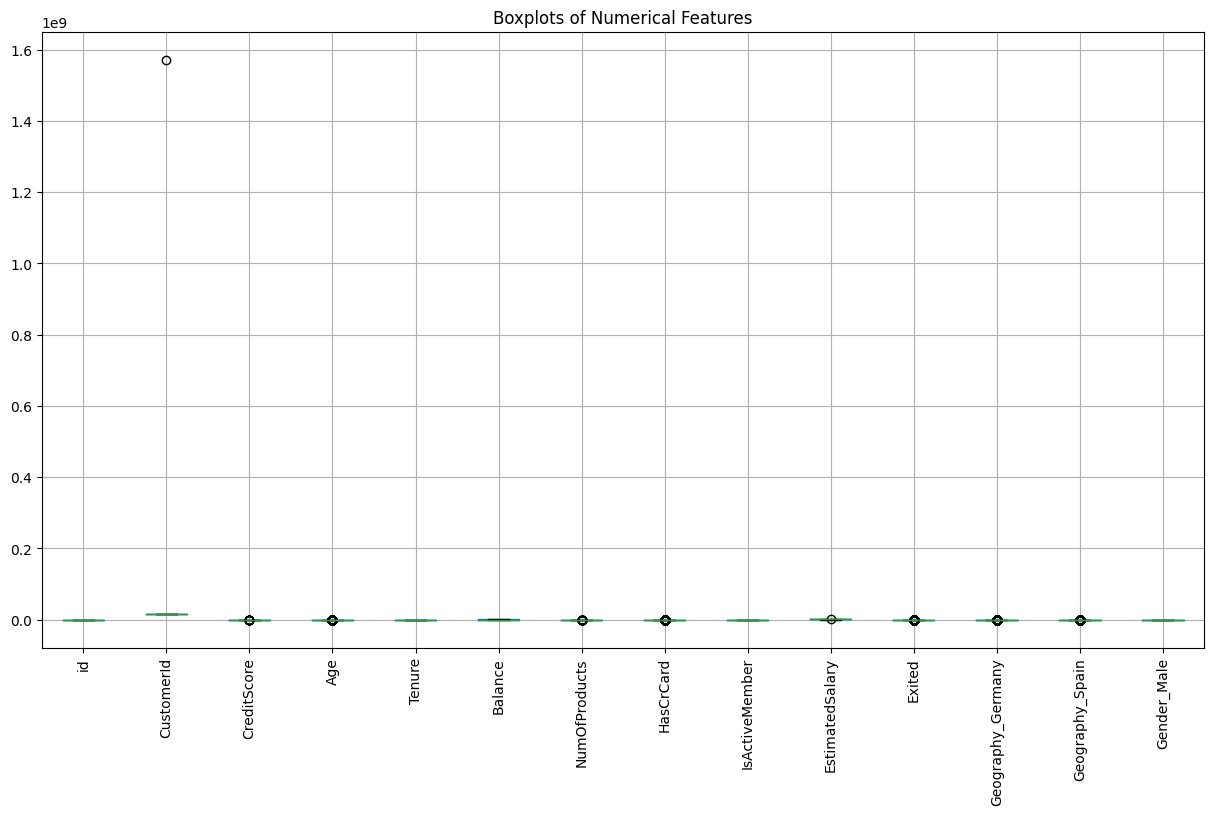

In [156]:
plt.figure(figsize=(15, 8))
df.boxplot(rot=90)
plt.title("Boxplots of Numerical Features")
plt.show()

# Split features and target


In [157]:
X = df.drop('Exited', axis=1)
y = df['Exited']

# Add target column temporarily


In [158]:
df_corr = df.copy()
df_corr["Exited"] = y

# Heatmap of correlations


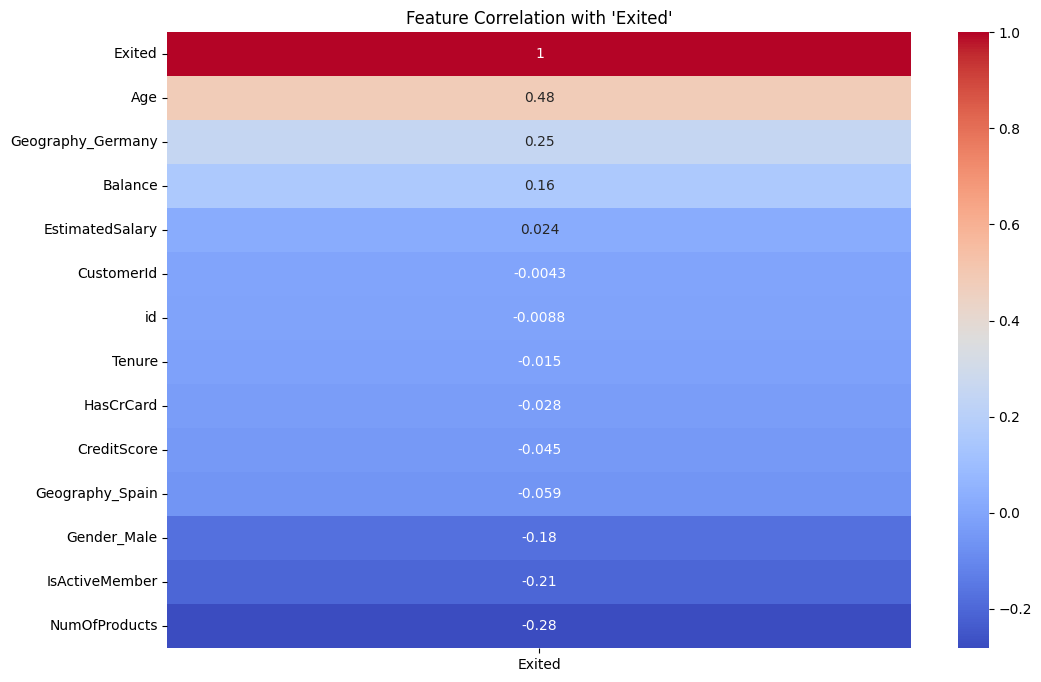

In [159]:
corr_matrix = df_corr.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['Exited']].sort_values('Exited', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with 'Exited'")
plt.show()

# Distribution of target variable


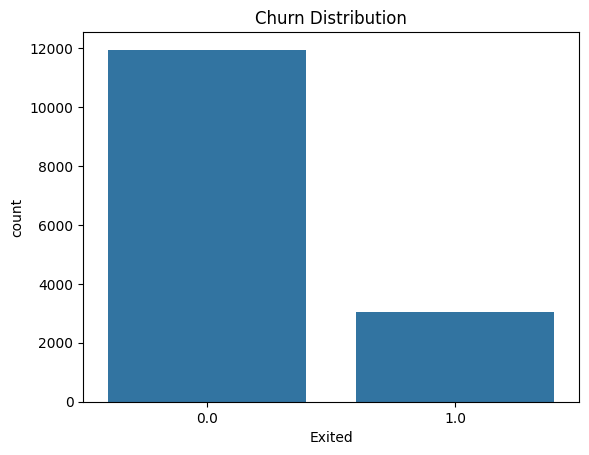

In [160]:
sns.countplot(x='Exited', data=eda_df)
plt.title('Churn Distribution')
plt.show()

# Age distribution by churn


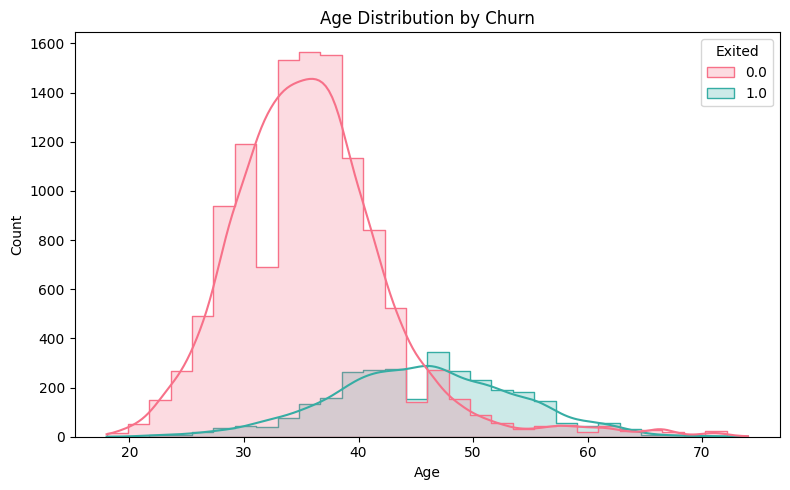

In [161]:

plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Age', hue='Exited', kde=True, bins=30, palette="husl", element="step")
plt.title("Age Distribution by Churn")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# Preprocess function


In [162]:
def preprocess(df):
    df = df.copy()
    for col in ['RowNumber', 'CustomerId', 'Surname']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
    return df


# Prepare training set


In [163]:
corr_target = df.corr(numeric_only=True)['Exited'].abs()
selected_features = corr_target[corr_target > 0.05].index.tolist()
selected_features.remove('Exited') 
X_filtered = df[selected_features]

# Impute + scale


In [164]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_filtered)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train/test split (optional)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Check Missing values

In [166]:
print("Missing values in X_train:", np.isnan(X_train).sum())
print("Missing values in X_test:", np.isnan(X_test).sum())

Missing values in X_train: 0
Missing values in X_test: 0


# Train Logistic Regression model


In [167]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)


# Accuracy

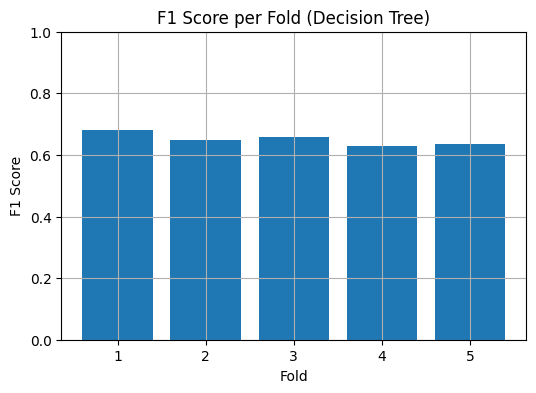

In [168]:
scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')

plt.figure(figsize=(6, 4))
plt.bar(range(1, 6), scores)
plt.title("F1 Score per Fold (Decision Tree)")
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [169]:
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

# Save model and preprocessing pipeline


In [170]:


joblib.dump(model, "../models/model_logistic.pkl")
joblib.dump(imputer, "../imputer/imputer.pkl")
joblib.dump(scaler, "../scaler/scaler.pkl")
joblib.dump(X_filtered.columns, "../feature_columns/feature_columns.pkl")

print(" Logistic model and preprocessors saved.")


 Logistic model and preprocessors saved.


# Predict on validation set


In [171]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Accuracy and F1 Score


In [172]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}\n")

Accuracy: 0.8360
F1 Score: 0.6564
ROC AUC: 0.8875



# Classification report


In [173]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89      2413
         1.0       0.56      0.80      0.66       587

    accuracy                           0.84      3000
   macro avg       0.75      0.82      0.77      3000
weighted avg       0.87      0.84      0.85      3000



# Confusion matrix


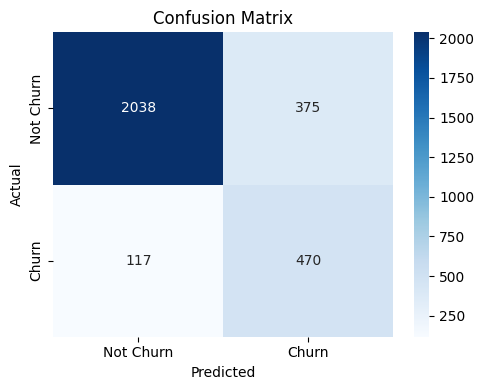

In [174]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve


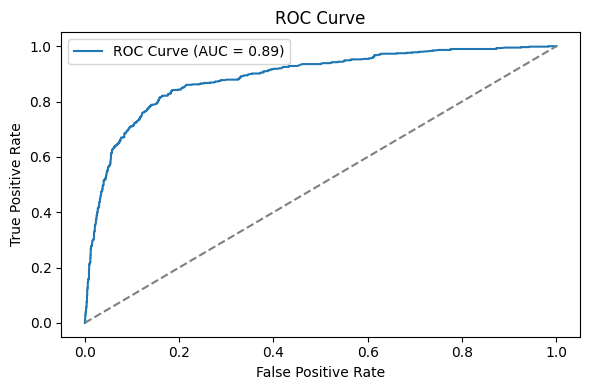

In [175]:

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()


# Load test data


In [176]:
test_df = pd.read_csv("../bank-customer-churn-prediction-challenge/test.csv")


# Preprocess


In [177]:
X_test_raw = preprocess(test_df)


# Align columns with training set


In [178]:
feature_columns = joblib.load("../feature_columns/feature_columns.pkl")
X_test_raw = X_test_raw.reindex(columns=feature_columns, fill_value=0)

# Apply imputer and scaler


In [179]:
imputer = joblib.load("../imputer/imputer.pkl")
scaler = joblib.load("../scaler/scaler.pkl")
X_test_imputed = imputer.transform(X_test_raw)
X_test_scaled = scaler.transform(X_test_imputed)

# Load model and predict probabilities


In [180]:
model = joblib.load("../models/model_logistic.pkl")
probas = model.predict_proba(X_test_scaled)[:, 1]

# Build submission


In [181]:
submission = pd.DataFrame({
    'id': test_df['id'] if 'id' in test_df.columns else test_df['CustomerId'],
    'Exited': probas
})
submission.to_csv("../submissions/submission_lr.csv", index=False)


# Write Scores to CSV

In [182]:
score_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1 Score", "ROC AUC"],
    "Score": [accuracy, f1, roc_auc]
})
score_df.to_csv("../scores/model_scores_logistic.csv", index=False)